#### Link:
1. https://www.kaggle.com/code/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert
2. https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk

## NLP - EDA, Bag of Words, TF IDF, GloVe, BERT (from link 1)

#### NLP:
* EDA (with WordCloud)
* Bag of Words
* TF IDF
* GloVe
* BERT with TFHub and with Submission
* PCA visualization for the main models
* Showing Confusion Matrices for BERT, Simpletransformers with DistilBERT and GloVe

#### Table of Contents
* My upgrade BERT model
* Previous commits: with training tweets correction
* Previous commits: parameters and LB scores
* Import libraries
* Download data
* EDA
* Data Cleaning
* WordCloud
* Bag of Words Counts
* TF IDF
* GloVe
* BERT using TFHub
* Submission
* Showing Confusion Matrices

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
from nltk.corpus import stopwords
from nltk.util import ngrams

In [3]:
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix


In [4]:
from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

In [5]:
import re
from nltk.tokenize import word_tokenize
import gensim
import string

In [6]:
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import torch

import warnings
warnings.simplefilter('ignore')


In [7]:
tweet= pd.read_csv('../Data/train.csv')
test=pd.read_csv('../Data/test.csv')
submission = pd.read_csv("../Data/sample_submission.csv")

In [8]:
print('There are {} rows and {} columns in train'.format(tweet.shape[0],tweet.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [9]:
tweet.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


#### EDA

In [15]:
# Class distribution

In [13]:
# extracting the number of examples of each class
Real_len = tweet[tweet['target'] == 1].shape[0]
Not_len = tweet[tweet['target'] == 0].shape[0]

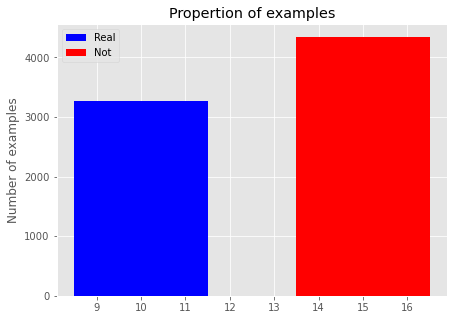

In [14]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [16]:
# Number of characters in tweets

In [17]:
tweet['length'] = tweet['text'].apply(len)

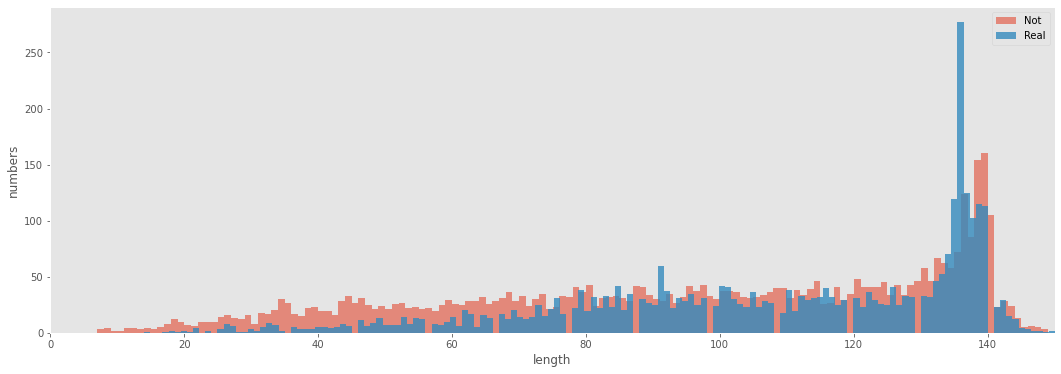

In [23]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

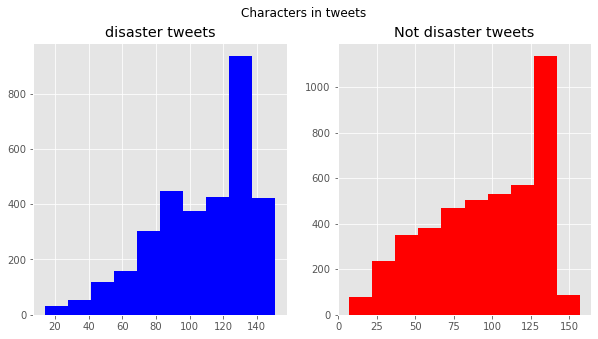

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

In [25]:
# Number of words in a tweet

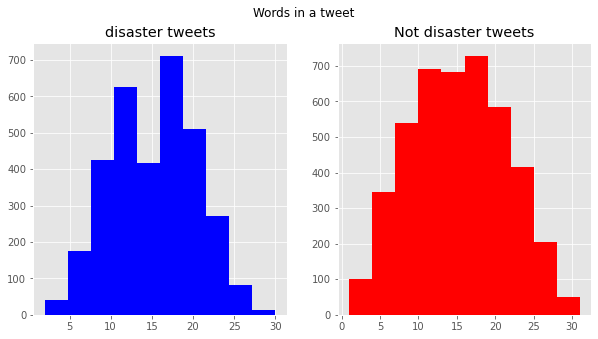

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [28]:
# Average word length in a tweet

Text(0.5, 0.98, 'Average word length in each tweet')

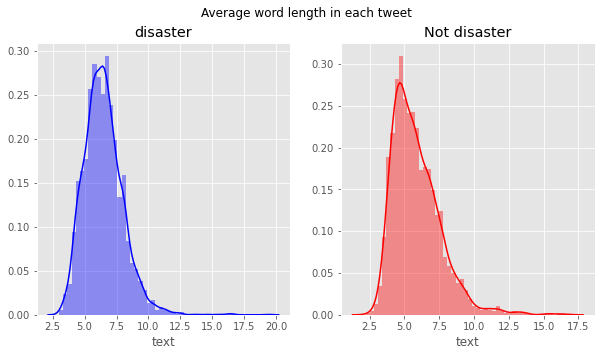

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Not disaster')
fig.suptitle('Average word length in each tweet')

In [10]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [11]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [12]:
# Common stopwords in tweets

In [13]:
corpus=create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [14]:
top

[('the', 1524),
 ('a', 1115),
 ('to', 1099),
 ('and', 840),
 ('of', 834),
 ('in', 720),
 ('you', 529),
 ('is', 512),
 ('for', 452),
 ('my', 442)]

In [15]:
# displaying the stopwords
np.array(stop)

array({'ain', 'herself', 'this', 'other', 'i', 'further', 'y', 'myself', "don't", "weren't", 'its', 'him', 'll', 'haven', 'again', 'o', 'very', 'mustn', 'who', 'from', 'has', 'below', 'here', 'into', 'those', 'wouldn', 'will', 'too', "hadn't", "you've", 'just', 'did', "you're", 'not', 'once', 'doesn', 'because', 'nor', 'own', 'himself', 'mightn', 'at', 'few', 'm', 'didn', "mightn't", "aren't", 'the', 'itself', 'how', "wasn't", 'over', 'there', "doesn't", 'only', 'we', "needn't", 'more', "wouldn't", 'what', 'by', 'won', 'am', 'shouldn', 'down', 'each', "it's", "that'll", 'between', 'up', 'any', 'or', 'both', 'such', 'me', 'can', 'should', "shan't", 'is', 'she', 'had', 'with', "shouldn't", 'it', 'they', "isn't", 'above', 'where', 'to', 'hasn', 'them', 'of', 'before', 'for', 'isn', 'an', 'yourselves', 'been', 'does', 'than', "haven't", 'couldn', "you'll", 'shan', 'his', 'yours', 'wasn', 'aren', 'then', 'against', 'under', "you'd", 'through', 'do', 'these', 'as', 'most', 'and', 'being', 'b

<BarContainer object of 10 artists>

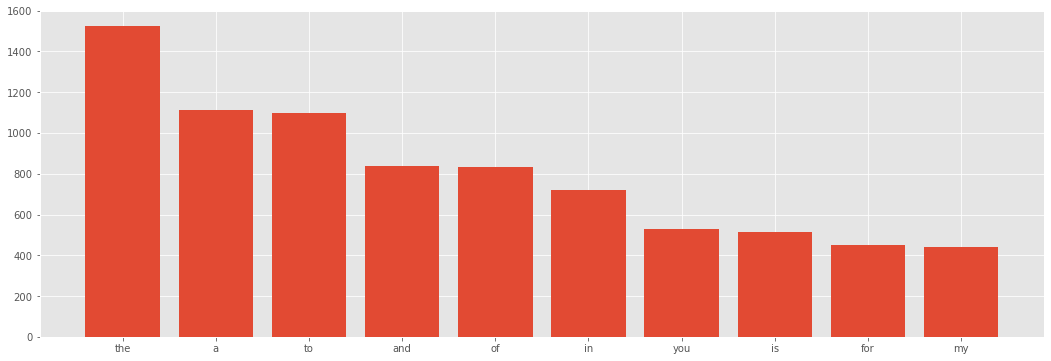

In [16]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

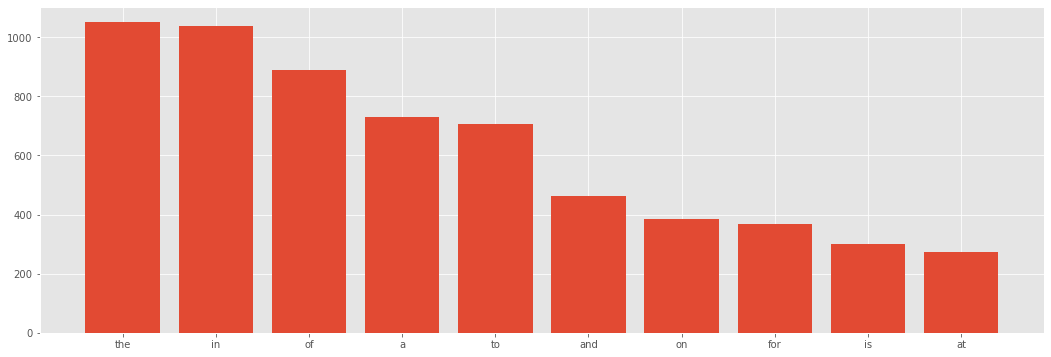

In [17]:
# Now,we will analyze tweets with class 1
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

#### Analyzing punctuations

<BarContainer object of 18 artists>

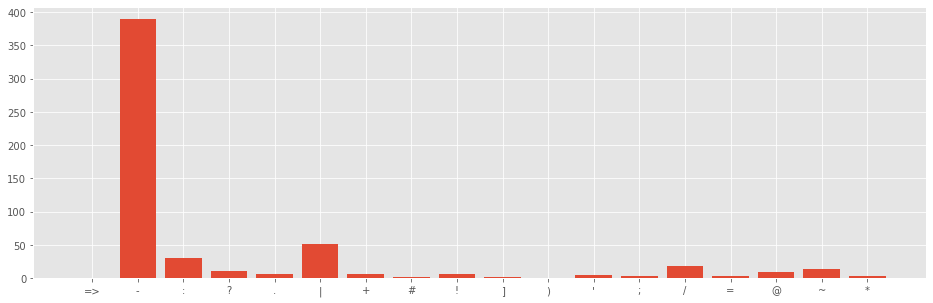

In [20]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 20 artists>

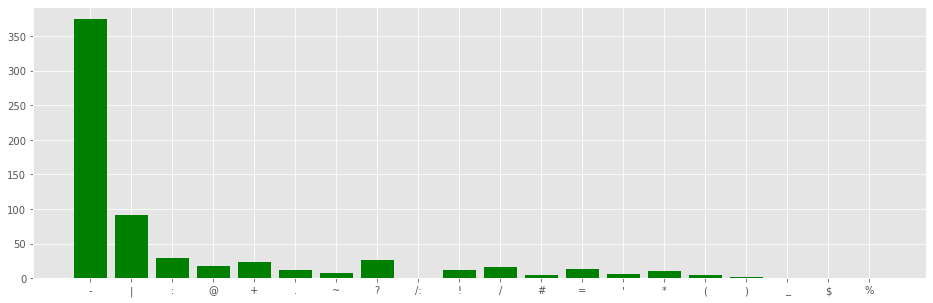

In [21]:
# Now,we will move on to class 0
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

#### Common words

In [22]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

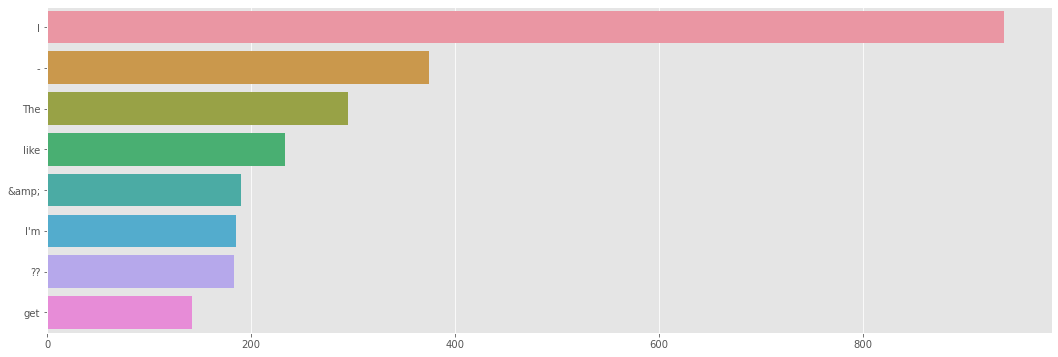

In [25]:
sns.barplot(x=y,y=x)

In [26]:
# Lot of cleaning needed 

#### N-gram analysis

In [27]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

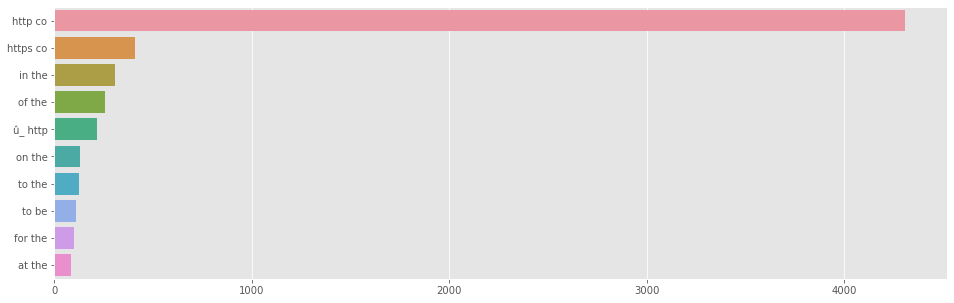

In [28]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

### Data Cleaning

In [36]:
df=pd.concat([tweet,test])
df.shape

(10876, 5)

In [37]:
# Removing urls
example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [38]:
df['text']=df['text'].apply(lambda x : remove_URL(x))

In [39]:
# Removing HTML tags
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [40]:
df['text']=df['text'].apply(lambda x : remove_html(x))

In [41]:
# Removing Emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [42]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [43]:
# Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [46]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

### WordCloud

In [49]:
corpus_new1 = create_corpus_df(df,1)
len(corpus_new1)

46269

In [57]:
corpus_new1[:10]

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 'earthquake',
 'May',
 'ALLAH']

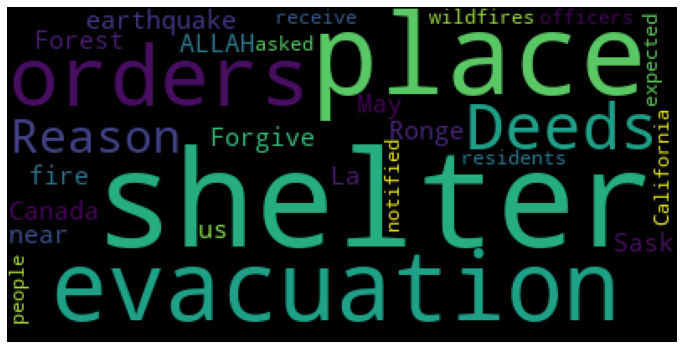

In [58]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [59]:
# Not Disaster

In [60]:
corpus_new0=create_corpus_df(df,0)
len(corpus_new0)

60478

In [61]:
corpus_new0[:10]

['Whats', 'up', 'man', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']

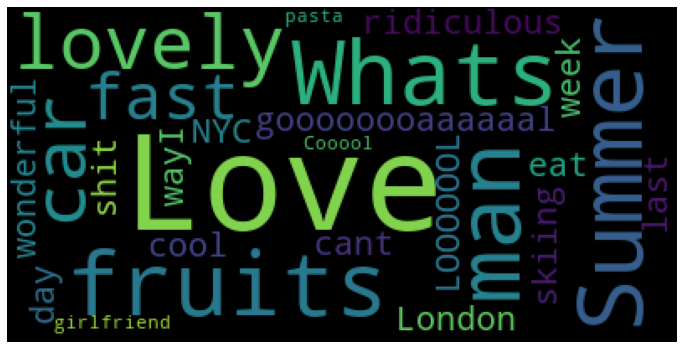

In [62]:
# Generating the wordcloud with the values under the category dataframe
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [63]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0
2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0
5,8,NaN,NaN,RockyFire Update California Hwy 20 closed in ...,1.0
6,10,NaN,NaN,flood disaster Heavy rain causes flash floodin...,1.0
7,13,NaN,NaN,Im on top of the hill and I can see a fire in ...,1.0
8,14,NaN,NaN,Theres an emergency evacuation happening now i...,1.0
9,15,NaN,NaN,Im afraid that the tornado is coming to our area,1.0


### Bag of Words Counts

In [65]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df["text"].tolist()
list_labels = df["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=1)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [72]:
y_train

[1.0,
 1.0,
 nan,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 nan,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 nan,
 0.0,
 1.0,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 1.0,
 nan,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 nan,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 nan,
 nan,
 0.0,
 1.0,
 1.0,
 1.0,
 nan,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 1.0,
 0.0,
 0.0,
 0.0,
 nan,
 1.0,
 nan,
 1.0,
 0.0,
 0.0,
 1.0,
 nan,
 0.0,
 nan,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 nan,
 0.0,
 0.0,
 1.0,
 nan,
 0.0,
 nan,
 nan,
 0.0,
 nan,
 1.0,
 nan,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 nan,
 1.0,
 1.0,
 nan,
 nan,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 nan,
 nan,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 0.0,
 nan,
 1.0,
 nan,
 nan,
 0.0,
 0.0,
 nan,
 1.0,
 nan,
 nan,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0

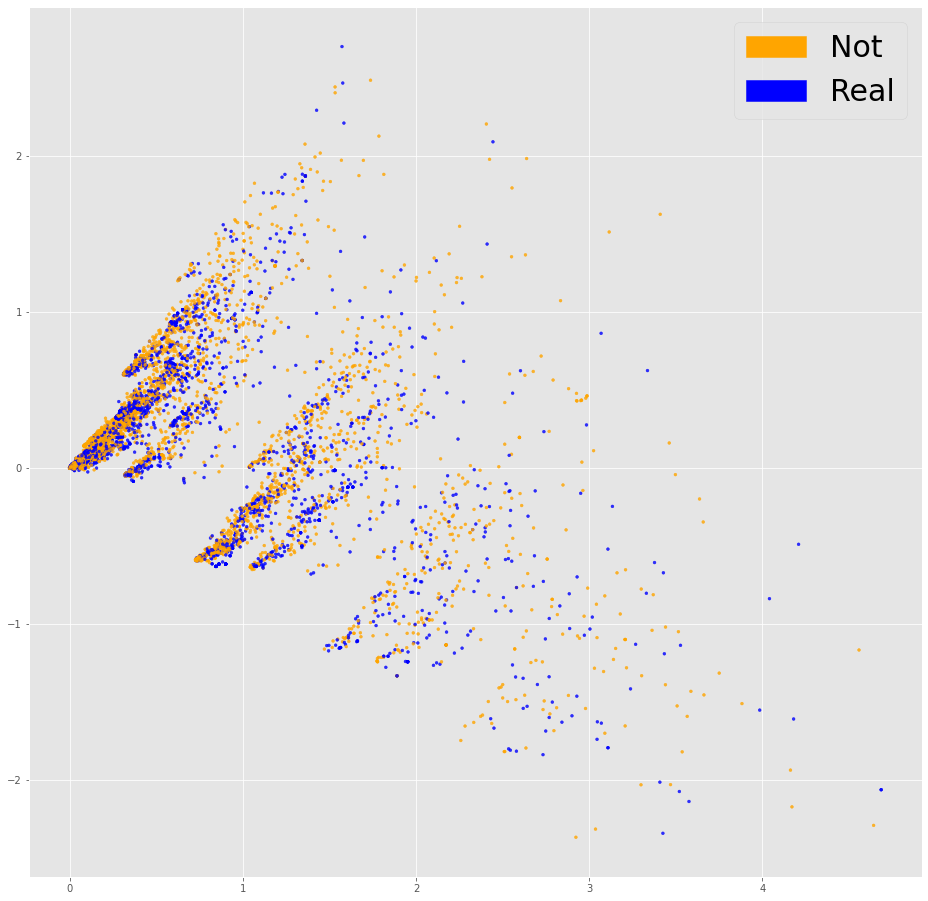

In [71]:
# Visualizing the embeddings
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

### TF IDF

In [73]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

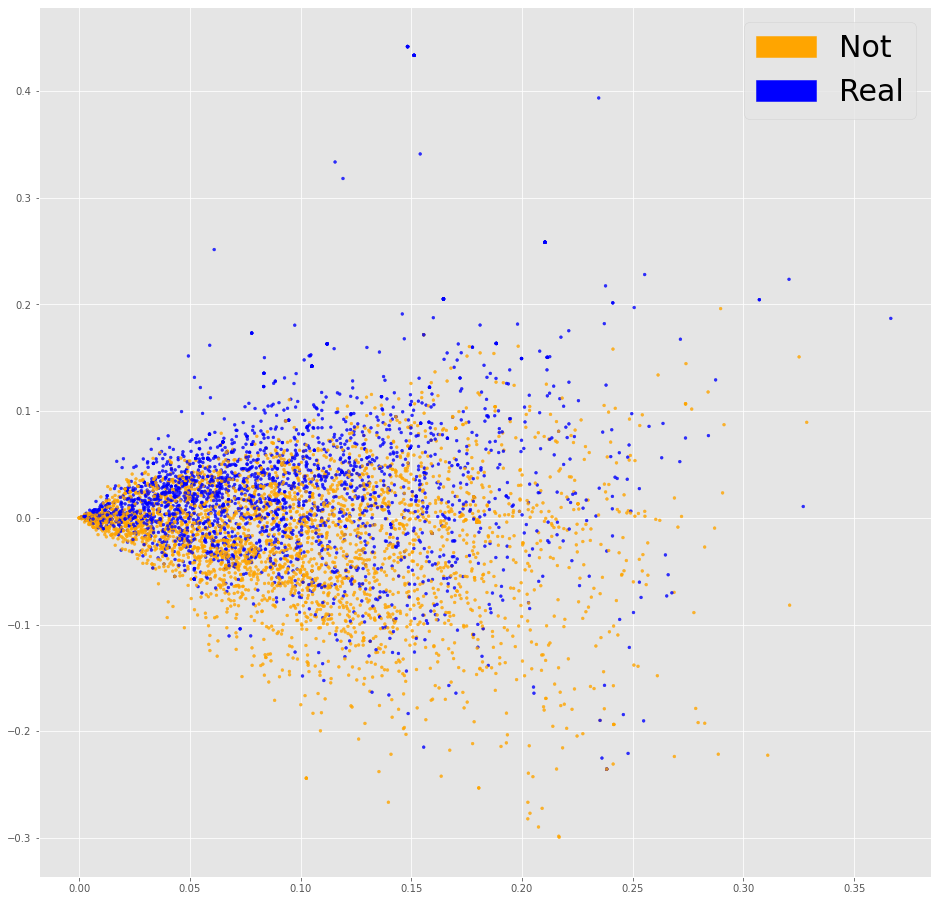

In [74]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

### GloVe

In [75]:
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [77]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [78]:
corpus=create_corpus_new(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:03<00:00, 3593.18it/s]


In [80]:
embedding_dict={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

### Incomplete